In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,roc_auc_score

In [4]:
# Read embeddings
data = pd.read_csv("../2.Feature extraction/embeddings/Azure_text-similarity-ada-002_embeddings.csv", index_col=0)

#### FEATURE ENGINEERING ####
# Choose embeddings to use
embedding_to_use = "embedding_cleaned_asr"
embeddings = ["embedding_asr","embedding_cleaned_asr","embedding_cleaned_asr_without_stopw","Unnamed: 0"]
embeddings.remove(embedding_to_use)
data = data.drop(columns=embeddings, axis = 1)

# Suffix column
def get_suffix_from_intent(intent: str) -> str:
    return intent.split("-")[-1].strip()
data["suffix"] = data.intent.apply(lambda x: get_suffix_from_intent(x))

# Create feature x embedding dimension
data["embedding"] = data[embedding_to_use].apply(eval).apply(np.array)
tags = data['embedding'].apply(pd.Series)
features = tags.rename(columns = lambda x : 'embedding_feature_' + str(x))
result = pd.concat([data, features], axis=1)
df = result.drop(columns=["embedding"], axis=1)

# Create sets
X = df.drop(columns=["label"], axis = 1)
y = df["label"]

# Encode label
le = preprocessing.LabelEncoder()
y_encoded = le.fit_transform(y)
print(list(le.classes_)) 

# Extract text features -> convert to category
cats = X.select_dtypes(exclude=np.number).columns.tolist()
for col in cats:
    X[col] = X[col].astype('category')

['no open', 'open']


In [6]:
#### VALIDATE MODEL #### 

xgboost_results = pd.DataFrame()
parameters_column = []
score_column = []
accuracy_test_column = []
recall_test_column = []
precision_test_column = []
f1_test_column = []
auc_test_column = []

accuracy_train_column = []
recall_train_column = []
precision_train_column = []
f1_train_column = []
auc_train_column = []

for i in range(10):
    print(f"Iteration {i}.")
    # Divide data in training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.1)

    # Validate parameters
    model = XGBClassifier(
                            objective= 'binary:logistic',
                            tree_method= "hist",
                            nthread=4,enable_categorical=True,
                            subsample=0.8,
                            colsample_bytree=0.8
                            )

    parameters = {
        'max_depth': range (2, 10, 2),
        'n_estimators': range(60, 220, 80),
        'learning_rate': [0.15, 0.1, 0.01, 0.05]
    }

    clf = GridSearchCV(model, parameters, n_jobs=-1, scoring='balanced_accuracy', verbose=2, refit=True)
    clf.fit(X_train, y_train)

    # Best parameters
    best_parameters = clf.best_params_ 
    best_score = clf.best_score_ 
    best_estimator = clf.best_estimator_

    parameters_column.append(best_parameters)
    score_column.append(best_score)
    print(f"Best score: {best_score}")

    # Prediction
    y_pred_test = best_estimator.predict(X_test)
    y_proba_test = best_estimator.predict_proba(X_test)
    accuracy_test = accuracy_score(y_test,y_pred_test)
    precision_test = precision_score(y_test,y_pred_test)
    recall_test = recall_score(y_test, y_pred_test)
    f1_test = f1_score(y_test,y_pred_test)
    mean_auc_test = roc_auc_score(y_test, y_proba_test[:,1], average="weighted")

    y_pred_train = best_estimator.predict(X_train)
    y_proba_train = best_estimator.predict_proba(X_train)
    accuracy_train = accuracy_score(y_train,y_pred_train)
    precision_train = precision_score(y_train,y_pred_train)
    recall_train = recall_score(y_train, y_pred_train)
    f1_train = f1_score(y_train,y_pred_train)
    mean_auc_train = roc_auc_score(y_train, y_proba_train[:,1], average="weighted")

    accuracy_test_column.append(accuracy_test)
    precision_test_column.append(precision_test)
    recall_test_column.append(recall_test)
    f1_test_column.append(f1_test)
    auc_test_column.append(mean_auc_test)

    accuracy_train_column.append(accuracy_train)
    precision_train_column.append(precision_train)
    recall_train_column.append(recall_train)
    f1_train_column.append(f1_train)
    auc_train_column.append(mean_auc_train)



xgboost_results["best_score"] = score_column
xgboost_results["best_parameters"] = parameters_column
xgboost_results["test_accuracy"] = accuracy_test_column
xgboost_results["test_precision"] = precision_test_column
xgboost_results["test_recall"] = recall_test_column
xgboost_results["test_f1"] = f1_test_column
xgboost_results["test_roc_auc"] = auc_test_column
xgboost_results["train_accuracy"] = accuracy_train_column
xgboost_results["train_precision"] = precision_train_column
xgboost_results["train_recall"] = recall_train_column
xgboost_results["train_f1"] = f1_train_column
xgboost_results["train_roc_auc"] = auc_train_column

Iteration 0.
Fitting 5 folds for each of 32 candidates, totalling 160 fits


[CV] END ...learning_rate=0.15, max_depth=2, n_estimators=60; total time=  38.8s
[CV] END ...learning_rate=0.15, max_depth=2, n_estimators=60; total time=  44.1s
[CV] END ...learning_rate=0.15, max_depth=2, n_estimators=60; total time=  44.1s
[CV] END ...learning_rate=0.15, max_depth=2, n_estimators=60; total time=  46.0s
[CV] END ...learning_rate=0.15, max_depth=2, n_estimators=60; total time=  46.7s
[CV] END ..learning_rate=0.15, max_depth=2, n_estimators=140; total time= 1.7min
[CV] END ..learning_rate=0.15, max_depth=2, n_estimators=140; total time= 1.7min
[CV] END ..learning_rate=0.15, max_depth=2, n_estimators=140; total time= 1.7min
[CV] END ...learning_rate=0.15, max_depth=4, n_estimators=60; total time= 1.3min
[CV] END ...learning_rate=0.15, max_depth=4, n_estimators=60; total time= 1.3min
[CV] END ...learning_rate=0.15, max_depth=4, n_estimators=60; total time= 1.3min
[CV] END ..learning_rate=0.15, max_depth=2, n_estimators=140; total time= 1.6min
[CV] END ..learning_rate=0.1

In [7]:
xgboost_results.to_csv('xgboost_azure_validation_model_10.csv')

### 3.Validation results

Experiments validation results.

#### Experiment 4: Azure Embeddings with ADA1 model and preprocessed text with stopwords

In [12]:
results = pd.read_csv("validation_results/xgboost_validate_results_model_6.csv", index_col=0)
results.head(10)

,best_score,best_parameters,test_accuracy,test_precision,test_recall,test_f1,test_roc_auc,train_accuracy,train_precision,train_recall,train_f1,train_roc_auc
0,0.787531,"{'learning_rate': 0.01, 'max_depth': 8, 'n_est...",0.800000,0.761194,0.879310,0.816000,0.879310,0.999027,0.998168,1.000000,0.999083,0.999973
1,0.790631,"{'learning_rate': 0.05, 'max_depth': 8, 'n_est...",0.826087,0.862069,0.806452,0.833333,0.896226,1.000000,1.000000,1.000000,1.000000,1.000000
2,0.813956,"{'learning_rate': 0.15, 'max_depth': 6, 'n_est...",0.730435,0.666667,0.851852,0.747967,0.820583,1.000000,1.000000,1.000000,1.000000,1.000000
3,0.790807,"{'learning_rate': 0.1, 'max_depth': 8, 'n_esti...",0.834783,0.762712,0.900000,0.825688,0.913846,1.000000,1.000000,1.000000,1.000000,1.000000
4,0.797140,"{'learning_rate': 0.05, 'max_depth': 2, 'n_est...",0.782609,0.703125,0.882353,0.782609,0.877145,0.915370,0.900172,0.947464,0.923213,0.975665
5,0.800697,"{'learning_rate': 0.1, 'max_depth': 6, 'n_esti...",0.808696,0.811594,0.861538,0.835821,0.879077,1.000000,1.000000,1.000000,1.000000,1.000000
6,0.797911,"{'learning_rate': 0.1, 'max_depth': 8, 'n_esti...",0.817391,0.805556,0.892308,0.846715,0.862769,1.000000,1.000000,1.000000,1.000000,1.000000
7,0.803392,"{'learning_rate': 0.1, 'max_depth': 8, 'n_esti...",0.730435,0.769231,0.757576,0.763359,0.814471,1.000000,1.000000,1.000000,1.000000,1.000000
8,0.783429,"{'learning_rate': 0.1, 'max_depth': 8, 'n_esti...",0.843478,0.833333,0.862069,0.847458,0.894132,1.000000,1.000000,1.000000,1.000000,1.000000
9,0.783393,"{'learning_rate': 0.1, 'max_depth': 4, 'n_esti...",0.886957,0.903226,0.888889,0.896000,0.937729,1.000000,1.000000,1.000000,1.000000,1.000000


In [13]:
# Metrics
print(f"Mean test accuracy: {round(results.test_accuracy.mean(),3)} +- {round(results.test_accuracy.std(),3)}")
print(f"Mean train accuracy: {round(results.train_accuracy.mean(),3)} +- {round(results.train_accuracy.std(),3)}")
print(f"Mean test precision: {round(results.test_precision.mean(),3)} +- {round(results.test_precision.std(),3)}")
print(f"Mean train precision: {round(results.train_precision.mean(),3)} +- {round(results.train_precision.std(),3)}")
print(f"Mean test recall: {round(results.test_recall.mean(),3)} +- {round(results.test_recall.std(),3)}")
print(f"Mean train recall: {round(results.train_recall.mean(),3)} +- {round(results.train_recall.std(),3)}")
print(f"Mean test f1 score: {round(results.test_f1.mean(),3)} +- {round(results.test_f1.std(),3)}")
print(f"Mean train f1 score: {round(results.train_f1.mean(),3)} +- {round(results.train_f1.std(),3)}")
print(f"Mean test ROC-AUC: {round(results.test_roc_auc.mean(),3)} +- {round(results.test_roc_auc.std(),3)}")
print(f"Mean train ROC-AUC: {round(results.train_roc_auc.mean(),3)} +- {round(results.train_roc_auc.std(),3)}")

Mean test accuracy: 0.806 +- 0.049
Mean train accuracy: 0.991 +- 0.027
Mean test precision: 0.788 +- 0.071
Mean train precision: 0.99 +- 0.032
Mean test recall: 0.858 +- 0.044
Mean train recall: 0.995 +- 0.017
Mean test f1 score: 0.819 +- 0.044
Mean train f1 score: 0.992 +- 0.024
Mean test ROC-AUC: 0.878 +- 0.038
Mean train ROC-AUC: 0.998 +- 0.008


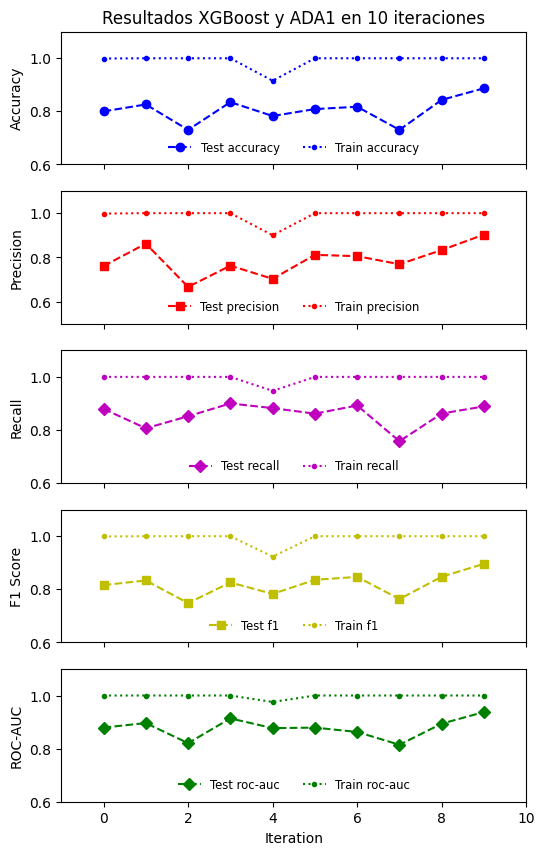

In [10]:
# Figures
acc_test = results.test_accuracy
precision_test = results.test_precision
recall_test = results.test_recall
f1_test = results.test_f1
roc_test = results.test_roc_auc

acc_train = results.train_accuracy
precision_train = results.train_precision
recall_train = results.train_recall
f1_train = results.train_f1
roc_train = results.train_roc_auc

x = np.array(range(0, 10))

fig,ax = plt.subplots(5,1, sharex=True,figsize=[6, 10])


ax[0].plot(x, acc_test, marker='o', color='b', linestyle='--', label='Test accuracy')
ax[0].plot(x, acc_train, marker='.', color='b', linestyle='dotted', label='Train accuracy')

ax[1].plot(x, precision_test, marker='s', color='r', linestyle='--', label='Test precision')
ax[1].plot(x, precision_train, marker='.', color='r', linestyle='dotted', label='Train precision')

ax[2].plot(x, recall_test,marker='D', color='m', linestyle='--', label='Test recall')
ax[2].plot(x, recall_train, marker='.', color='m', linestyle='dotted', label='Train recall')

ax[3].plot(x, f1_test, marker='s', color='y', linestyle='--', label='Test f1')
ax[3].plot(x, f1_train, marker='.', color='y', linestyle='dotted', label='Train f1')

ax[4].plot(x, roc_test,marker='D', color='g', linestyle='--', label='Test roc-auc')
ax[4].plot(x, roc_train, marker='.', color='g', linestyle='dotted', label='Train roc-auc')

ax[4].set_xlabel('Iteration')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlim(-1,10)
ax[0].set_ylim(0.6,1.1)
ax[1].set_ylabel('Precision')
ax[1].set_ylim(0.5,1.1)
ax[2].set_ylabel('Recall')
ax[2].set_ylim(0.6,1.1)
ax[3].set_ylabel('F1 Score')
ax[3].set_ylim(0.6,1.1)
ax[4].set_ylabel('ROC-AUC')
ax[4].set_ylim(0.6,1.1)
ax[0].set_title('Resultados XGBoost y ADA1 en 10 iteraciones')

ax[0].legend(loc='lower center', frameon=False,ncol=2,fontsize ='small')
ax[1].legend(loc='lower center', frameon=False,ncol=2,fontsize ='small')
ax[2].legend(loc='lower center', frameon=False,ncol=2,fontsize ='small')
ax[3].legend(loc='lower center', frameon=False,ncol=2,fontsize ='small')
ax[4].legend(loc='lower center', frameon=False,ncol=2, fontsize ='small')

plt.show()

#### Experiment 10: Azure Embeddings with ADA2 model and preprocessed text with stopwords

In [4]:
results = pd.read_csv("validation_results/xgboost_azure_validation_model_10.csv", index_col = 0)
results.head()

,best_score,best_parameters,test_accuracy,test_precision,test_recall,test_f1,test_roc_auc,train_accuracy,train_precision,train_recall,train_f1,train_roc_auc
0,0.835905,"{'learning_rate': 0.1, 'max_depth': 2, 'n_esti...",0.846154,0.819048,0.905263,0.860000,0.912523,0.894383,0.849036,0.961212,0.901649,0.966511
1,0.840003,"{'learning_rate': 0.05, 'max_depth': 4, 'n_est...",0.840659,0.824742,0.869565,0.846561,0.908816,0.998168,0.996390,1.000000,0.998192,0.999987
2,0.838063,"{'learning_rate': 0.15, 'max_depth': 8, 'n_est...",0.829670,0.814815,0.888889,0.850242,0.924790,1.000000,1.000000,1.000000,1.000000,1.000000
3,0.831546,"{'learning_rate': 0.05, 'max_depth': 8, 'n_est...",0.835165,0.795082,0.950980,0.866071,0.897549,1.000000,1.000000,1.000000,1.000000,1.000000
4,0.827068,"{'learning_rate': 0.05, 'max_depth': 4, 'n_est...",0.873626,0.858491,0.919192,0.887805,0.938299,0.996337,0.992745,1.000000,0.996359,0.999997
5,0.839740,"{'learning_rate': 0.05, 'max_depth': 4, 'n_est...",0.824176,0.792793,0.907216,0.846154,0.918617,0.998168,0.996368,1.000000,0.998181,0.999997
6,0.836125,"{'learning_rate': 0.05, 'max_depth': 4, 'n_est...",0.835165,0.822034,0.915094,0.866071,0.916212,0.996337,0.993888,0.998771,0.996324,0.999993
7,0.838902,"{'learning_rate': 0.05, 'max_depth': 4, 'n_est...",0.813187,0.792079,0.860215,0.824742,0.905038,0.997558,0.995187,1.000000,0.997587,0.999991
8,0.833876,"{'learning_rate': 0.1, 'max_depth': 4, 'n_esti...",0.835165,0.780000,0.906977,0.838710,0.916303,0.993895,0.988152,1.000000,0.994041,0.999945
9,0.829847,"{'learning_rate': 0.1, 'max_depth': 8, 'n_esti...",0.846154,0.810000,0.900000,0.852632,0.934058,1.000000,1.000000,1.000000,1.000000,1.000000


In [6]:
# Metrics
print(f"Mean test accuracy: {round(results.test_accuracy.mean(),3)} +- {round(results.test_accuracy.std(),3)}")
print(f"Mean train accuracy: {round(results.train_accuracy.mean(),3)} +- {round(results.train_accuracy.std(),3)}")
print(f"Mean test precision: {round(results.test_precision.mean(),3)} +- {round(results.test_precision.std(),3)}")
print(f"Mean train precision: {round(results.train_precision.mean(),3)} +- {round(results.train_precision.std(),3)}")
print(f"Mean test recall: {round(results.test_recall.mean(),3)} +- {round(results.test_recall.std(),3)}")
print(f"Mean train recall: {round(results.train_recall.mean(),3)} +- {round(results.train_recall.std(),3)}")
print(f"Mean test f1 score: {round(results.test_f1.mean(),3)} +- {round(results.test_f1.std(),3)}")
print(f"Mean train f1 score: {round(results.train_f1.mean(),3)} +- {round(results.train_f1.std(),3)}")
print(f"Mean test ROC-AUC: {round(results.test_roc_auc.mean(),3)} +- {round(results.test_roc_auc.std(),3)}")
print(f"Mean train ROC-AUC: {round(results.train_roc_auc.mean(),3)} +- {round(results.train_roc_auc.std(),3)}")

Mean test accuracy: 0.838 +- 0.016
Mean train accuracy: 0.987 +- 0.033
Mean test precision: 0.811 +- 0.022
Mean train precision: 0.981 +- 0.047
Mean test recall: 0.902 +- 0.026
Mean train recall: 0.996 +- 0.012
Mean test f1 score: 0.854 +- 0.017
Mean train f1 score: 0.988 +- 0.03
Mean test ROC-AUC: 0.917 +- 0.013
Mean train ROC-AUC: 0.997 +- 0.011


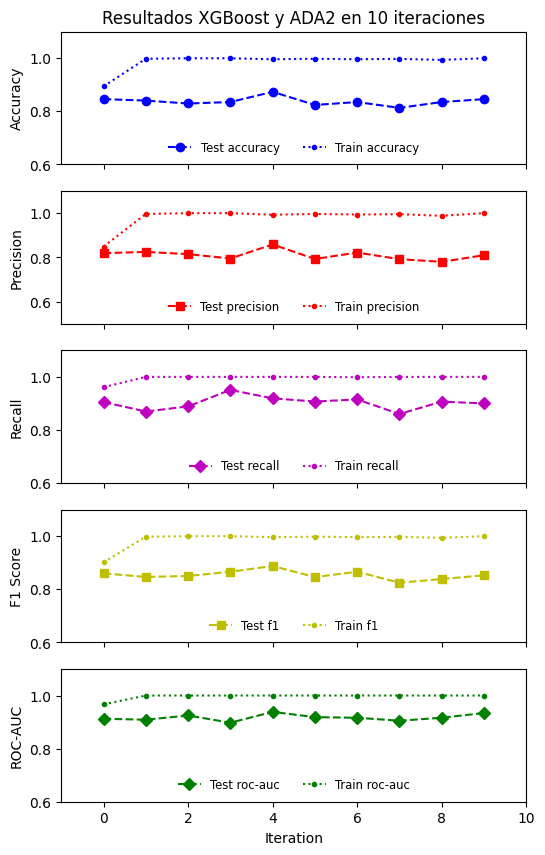

In [8]:
# Figures
acc_test = results.test_accuracy
precision_test = results.test_precision
recall_test = results.test_recall
f1_test = results.test_f1
roc_test = results.test_roc_auc

acc_train = results.train_accuracy
precision_train = results.train_precision
recall_train = results.train_recall
f1_train = results.train_f1
roc_train = results.train_roc_auc

x = np.array(range(0, 10))

fig,ax = plt.subplots(5,1, sharex=True,figsize=[6, 10])


ax[0].plot(x, acc_test, marker='o', color='b', linestyle='--', label='Test accuracy')
ax[0].plot(x, acc_train, marker='.', color='b', linestyle='dotted', label='Train accuracy')

ax[1].plot(x, precision_test, marker='s', color='r', linestyle='--', label='Test precision')
ax[1].plot(x, precision_train, marker='.', color='r', linestyle='dotted', label='Train precision')

ax[2].plot(x, recall_test,marker='D', color='m', linestyle='--', label='Test recall')
ax[2].plot(x, recall_train, marker='.', color='m', linestyle='dotted', label='Train recall')

ax[3].plot(x, f1_test, marker='s', color='y', linestyle='--', label='Test f1')
ax[3].plot(x, f1_train, marker='.', color='y', linestyle='dotted', label='Train f1')

ax[4].plot(x, roc_test,marker='D', color='g', linestyle='--', label='Test roc-auc')
ax[4].plot(x, roc_train, marker='.', color='g', linestyle='dotted', label='Train roc-auc')

ax[4].set_xlabel('Iteration')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlim(-1,10)
ax[0].set_ylim(0.6,1.1)
ax[1].set_ylabel('Precision')
ax[1].set_ylim(0.5,1.1)
ax[2].set_ylabel('Recall')
ax[2].set_ylim(0.6,1.1)
ax[3].set_ylabel('F1 Score')
ax[3].set_ylim(0.6,1.1)
ax[4].set_ylabel('ROC-AUC')
ax[4].set_ylim(0.6,1.1)
ax[0].set_title('Resultados XGBoost y ADA2 en 10 iteraciones')

ax[0].legend(loc='lower center', frameon=False,ncol=2,fontsize ='small')
ax[1].legend(loc='lower center', frameon=False,ncol=2,fontsize ='small')
ax[2].legend(loc='lower center', frameon=False,ncol=2,fontsize ='small')
ax[3].legend(loc='lower center', frameon=False,ncol=2,fontsize ='small')
ax[4].legend(loc='lower center', frameon=False,ncol=2, fontsize ='small')

plt.show()